In [3]:
using ControlSystems
using DSP
using PyPlot

include("help_fcns.jl")
include("IterativeLearningControl.jl")
include("PyControlPlots.jl")

include("init_llrf.jl")

In [4]:
h = 1e-7
γ = 2π*110e3
τ = 1e-6
P = c2d(DemoSystems.fotd(;T=1/γ, τ=τ), Ts_reg);

In [5]:
pi_params = amigo_pi_design(1/γ, τ, 1)

C = c2d(pi_ss(pi_params[1], pi_params[2], 1/(2π*2e6)), Ts_reg)[1];

In [6]:
Ω = 2π*logspace(2, 6.3, 200)

C_fr = freqresp(C, Ω)[:]
P_fr = freqresp(P, Ω)[:]
L_fr = freqresp(P*C, Ω)[:];

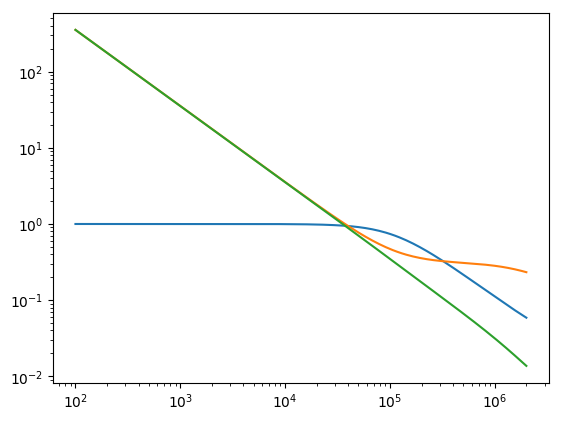

In [7]:
loglog(Ω/2π, abs.(P_fr))
loglog(Ω/2π, abs.(C_fr))
loglog(Ω/2π, abs.(L_fr))
show(block=false)

In [8]:
# ILC parameters
κ = 0.5 # gain
delta = -18 # nbr of sample to shift (corresponds to netgative delay)

# Butter worth filter
f_Q_3dB = 3e5 # (Hz)
Qbar = PolynomialRatio(digitalfilter(Lowpass(f_Q_3dB/2, fs=1/h), Butterworth(2))); # Divide by 2 (due to fwd-bwd) not quite right


In [12]:
N_samples_ILC = 10000

t = range(0, step=Ts_reg, length=N_samples_ILC)

u_ILC = zeros(size(t))

e = zeros(length(t))

N_iters = 50

y_hist = zeros(length(t), N_iters);
u_hist = zeros(length(t), N_iters);
